In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Higgs.tools.ImplementationUtils import fromHB5Table2, implementPairProductionLimit
from Higgs import bounds as HB
from Higgs import predictions as HP
from Higgs import Predictions

import os, sys

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
import MassResolutions as resolution


# LEP `ee -> Hi Hj -> tautau bb` [hep-ex/0602042](https://arxiv.org/abs/hep-ex/0602042)

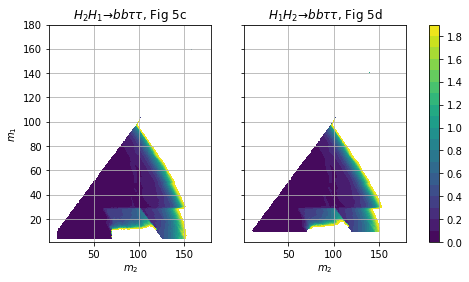

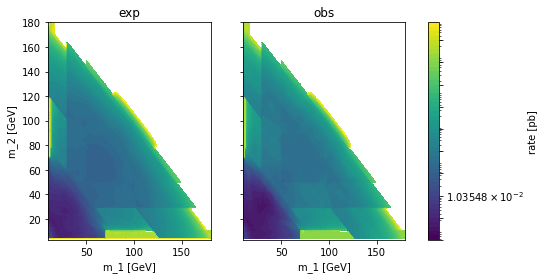

Looks good. Saving this to nonres_LEP_LEPComb_3.json


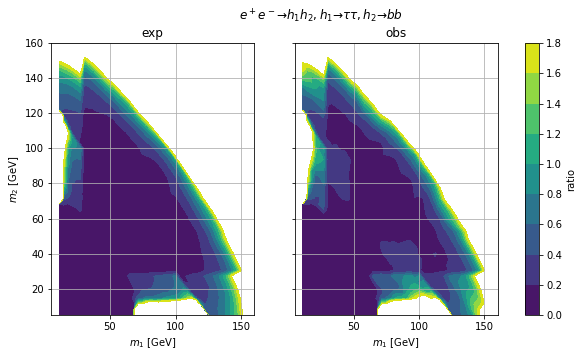

In [2]:
dfH2bb = fromHB5Table2("table23full", "LEP", p1Name="1", p2Name="2")
dfH1bbSwapped = fromHB5Table2("table24full", "LEP", p1Name="2", p2Name="1")
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), sharex=True, sharey=True)
cf = axes[0].tricontourf(dfH2bb.m1, dfH2bb.m2, dfH2bb.exp, levels=np.arange(0, 2, 0.1))
axes[0].set_title(r"$H_2 H_1 \to bb \tau\tau$, Fig 5c")
axes[1].tricontourf(
    dfH1bbSwapped.m2, dfH1bbSwapped.m1, dfH1bbSwapped.exp, levels=np.arange(0, 2, 0.1)
)
axes[1].set_title(r"$H_1 H_2 \to bb\tau\tau$, Fig 5d")
for ax in axes:
    ax.grid()
    ax.set_xlabel("$m_2$")
axes[0].set_ylabel("$m_1$")
fig.colorbar(cf, ax=axes)
plt.show()

assert np.allclose(np.unique(dfH2bb.m1), np.unique(dfH1bbSwapped.m1))
assert np.allclose(np.unique(dfH2bb.m2), np.unique(dfH1bbSwapped.m2))

# merge both using H1 -> tautau, H2 -> bb
df = dfH2bb.sort_values(["m1", "m2"]).reset_index(drop=True)
dfH1bbSwapped.sort_values(["m1", "m2"], inplace=True)
dfH1bbSwapped.reset_index(drop=True, inplace=True)

df.loc[(df.exp < 0), "exp"] = dfH1bbSwapped.loc[(df.exp < 0), "exp"]
df.loc[(df.obs < 0), "obs"] = dfH1bbSwapped.loc[(df.obs < 0), "obs"]

df = df.loc[(df.m1 >= 10) & (df.m2 >= 3)].reset_index(drop=True)
df.loc[(df.obs < 0) | (df.obs > 1e3), "obs"] = 1e6
df.loc[(df.exp < 0) | (df.exp > 1e3), "exp"] = 1e6

limitFile = implementPairProductionLimit(
    711130,
    {"firstDecay": ["tautau"], "secondDecay": ["bb"]},
    "Fig 5c,d",
    df,
    idSuffix=20,
    luminosity=2.6,
    massResolution={
        "firstParticle": resolution.LEPZH,  # certainly not better
        "secondParticle": resolution.LEPZH,  # same
    },
)

lim = HB.Limit(limitFile)
pred = Predictions()
h1 = pred.addParticle(HP.NeutralScalar("h1"))
h2 = pred.addParticle(HP.NeutralScalar("h2"))
h1.setDecayWidth("tautau", 1)
h2.setDecayWidth("bb", 1)
pred.setBsmPairCxn("LEP", "h1", "h2", 1)


def testAgainstLimit(m1, m2):
    h1.setMass(m1)
    h2.setMass(m2)
    app = lim.apply(pred)
    if len(app) == 0:
        return (1e-6, 1e-6)
    return (app[0].expRatio(), app[0].obsRatio())


ms = np.linspace(5, 160)
test = np.frompyfunc(testAgainstLimit, 2, 2)
expR, obsR = test(*np.meshgrid(ms, ms))
fig, axes = plt.subplots(figsize=(10, 5), ncols=2, sharex=True, sharey=True)
cf = axes[0].contourf(ms, ms, 1 / expR, levels=np.arange(0, 2, 0.2))
axes[1].contourf(ms, ms, 1 / obsR, levels=np.arange(0, 2, 0.2))
axes[0].set_title("exp")
axes[1].set_title("obs")
for ax in axes:
    ax.grid()
    ax.set_xlabel("$m_1$ [GeV]")
axes[0].set_ylabel("$m_2$ [GeV]")
fig.colorbar(cf, ax=axes, label="ratio")
fig.suptitle(r"$e^+e^-\to h_1 h_2, h_1 \to \tau\tau, h_2 \to bb$")
plt.show()
